# Requirements

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import f1_score, r2_score, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
import missingno as msno
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier

# Laboratory Exercise - Run Mode (8 points)

## The Mental Health Diagnosis and Treatment Monitoring Dataset
The dataset contains information on 500 individuals, focusing on mental health diagnoses, treatment plans, and outcomes. Key features include patient demographics such as age and gender, as well as specific mental health conditions (e.g., anxiety, depression, etc.). The dataset also captures symptom severity, mood scores, sleep quality, and stress levels, all rated on a scale of 1 to 10, providing insight into the patient's mental and physical well-being. Additionally, it includes details on treatment plans, including prescribed medications (e.g., SSRIs, antidepressants, etc.), therapy types (e.g., CBT, DBT, etc.), and treatment duration. Progress tracking is also incorporated, with ratings for treatment progress and AI-detected emotional state, alongside adherence to the treatment plan. The 'outcome' attribute, which indicates whether the treatment was improved, deteriorated, or unaffected, serves as the target variable for the analysis, while the remaining attributes can be used to explore and model the factors affecting mental health treatment outcomes.

Load the dataset into a `pandas` data frame.

In [111]:
df = pd.read_csv('mental_health_diagnosis_treatment_data.csv')

In [112]:
df

,Patient ID,Age,Gender,Diagnosis,Symptom Severity (1-10),Mood Score (1-10),Sleep Quality (1-10),Physical Activity (hrs/week),Medication,Therapy Type,Treatment Start Date,Treatment Duration (weeks),Stress Level (1-10),Outcome,Treatment Progress (1-10),AI-Detected Emotional State,Adherence to Treatment (%)
0,1,43.0,Female,Major Depressive Disorder,10,5,8,NaN,Mood Stabilizers,Interpersonal Therapy,2024-01-25,11,NaN,Deteriorated,7,Anxious,66
1,2,40.0,Female,Major Depressive Disorder,9,5,4,7.0,Antipsychotics,Interpersonal Therapy,2024-02-27,11,7.0,No Change,7,Neutral,78
2,3,55.0,Female,Major Depressive Disorder,6,3,4,NaN,SSRIs,Mindfulness-Based Therapy,2024-03-20,14,NaN,Deteriorated,5,Happy,62
3,4,34.0,Female,Major Depressive Disorder,6,3,6,5.0,SSRIs,Mindfulness-Based Therapy,2024-03-29,8,8.0,Deteriorated,10,Excited,72
4,5,52.0,Male,Panic Disorder,7,6,6,8.0,Anxiolytics,Interpersonal Therapy,2024-03-18,12,5.0,Deteriorated,6,Excited,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,NaN,Male,Generalized Anxiety,10,4,8,NaN,Mood Stabilizers,Dialectical Behavioral Therapy,2024-04-09,8,NaN,Improved,10,Depressed,73
496,497,22.0,Male,Panic Disorder,5,6,6,7.0,Benzodiazepines,Mindfulness-Based Therapy,2024-02-05,13,6.0,Deteriorated,8,Happy,86
497,498,23.0,Male,Major Depressive Disorder,7,3,4,NaN,Antidepressants,Cognitive Behavioral Therapy,2024-03-24,10,NaN,Deteriorated,5,Neutral,87
498,499,48.0,Male,Bipolar Disorder,9,4,6,9.0,Antidepressants,Mindfulness-Based Therapy,2024-03-22,10,6.0,Improved,7,Anxious,73


Preprocess the input and the output variables appropriately.

In [113]:
encoder = LabelEncoder()

In [114]:
encoded_values = encoder.fit_transform(df['Gender'])

In [115]:
encoder.classes_

array(['Female', 'Male'], dtype=object)

In [116]:
df['Gender'] = encoded_values

In [117]:
encoded_values = encoder.fit_transform(df['Diagnosis'])
df['Diagnosis'] = encoded_values

In [118]:
encoded_values = encoder.fit_transform(df['Medication'])
df['Medication'] = encoded_values

In [119]:
encoded_values = encoder.fit_transform(df['Therapy Type'])
df['Therapy Type'] = encoded_values

In [120]:
encoded_values = encoder.fit_transform(df['Outcome'])
df['Outcome'] = encoded_values

In [121]:
encoded_values = encoder.fit_transform(df['AI-Detected Emotional State'])
df['AI-Detected Emotional State'] = encoded_values

In [122]:
df

,Patient ID,Age,Gender,Diagnosis,Symptom Severity (1-10),Mood Score (1-10),Sleep Quality (1-10),Physical Activity (hrs/week),Medication,Therapy Type,Treatment Start Date,Treatment Duration (weeks),Stress Level (1-10),Outcome,Treatment Progress (1-10),AI-Detected Emotional State,Adherence to Treatment (%)
0,1,43.0,0,2,10,5,8,NaN,4,2,2024-01-25,11,NaN,0,7,0,66
1,2,40.0,0,2,9,5,4,7.0,1,2,2024-02-27,11,7.0,2,7,4,78
2,3,55.0,0,2,6,3,4,NaN,5,3,2024-03-20,14,NaN,0,5,3,62
3,4,34.0,0,2,6,3,6,5.0,5,3,2024-03-29,8,8.0,0,10,2,72
4,5,52.0,1,3,7,6,6,8.0,2,2,2024-03-18,12,5.0,0,6,2,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,NaN,1,1,10,4,8,NaN,4,1,2024-04-09,8,NaN,1,10,1,73
496,497,22.0,1,3,5,6,6,7.0,3,3,2024-02-05,13,6.0,0,8,3,86
497,498,23.0,1,2,7,3,4,NaN,0,0,2024-03-24,10,NaN,0,5,4,87
498,499,48.0,1,0,9,4,6,9.0,0,3,2024-03-22,10,6.0,1,7,0,73


Explore the dataset using visualizations of your choice.

In [123]:
df.drop('Patient ID', axis=1, inplace=True)

In [124]:
df

,Age,Gender,Diagnosis,Symptom Severity (1-10),Mood Score (1-10),Sleep Quality (1-10),Physical Activity (hrs/week),Medication,Therapy Type,Treatment Start Date,Treatment Duration (weeks),Stress Level (1-10),Outcome,Treatment Progress (1-10),AI-Detected Emotional State,Adherence to Treatment (%)
0,43.0,0,2,10,5,8,NaN,4,2,2024-01-25,11,NaN,0,7,0,66
1,40.0,0,2,9,5,4,7.0,1,2,2024-02-27,11,7.0,2,7,4,78
2,55.0,0,2,6,3,4,NaN,5,3,2024-03-20,14,NaN,0,5,3,62
3,34.0,0,2,6,3,6,5.0,5,3,2024-03-29,8,8.0,0,10,2,72
4,52.0,1,3,7,6,6,8.0,2,2,2024-03-18,12,5.0,0,6,2,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,1,1,10,4,8,NaN,4,1,2024-04-09,8,NaN,1,10,1,73
496,22.0,1,3,5,6,6,7.0,3,3,2024-02-05,13,6.0,0,8,3,86
497,23.0,1,2,7,3,4,NaN,0,0,2024-03-24,10,NaN,0,5,4,87
498,48.0,1,0,9,4,6,9.0,0,3,2024-03-22,10,6.0,1,7,0,73


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Diagnosis'}>,
        <Axes: title={'center': 'Symptom Severity (1-10)'}>],
       [<Axes: title={'center': 'Mood Score (1-10)'}>,
        <Axes: title={'center': 'Sleep Quality (1-10)'}>,
        <Axes: title={'center': 'Physical Activity (hrs/week)'}>,
        <Axes: title={'center': 'Medication'}>],
       [<Axes: title={'center': 'Therapy Type'}>,
        <Axes: title={'center': 'Treatment Duration (weeks)'}>,
        <Axes: title={'center': 'Stress Level (1-10)'}>,
        <Axes: title={'center': 'Outcome'}>],
       [<Axes: title={'center': 'Treatment Progress (1-10)'}>,
        <Axes: title={'center': 'AI-Detected Emotional State'}>,
        <Axes: title={'center': 'Adherence to Treatment (%)'}>, <Axes: >]],
      dtype=object)

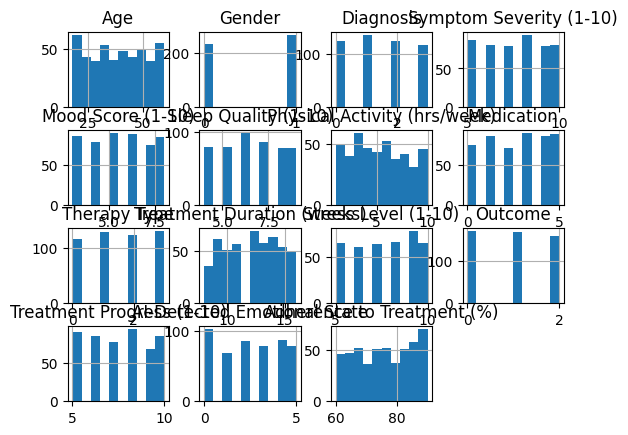

In [125]:
df.hist()

Check if the dataset is balanced.

<Axes: xlabel='Outcome'>

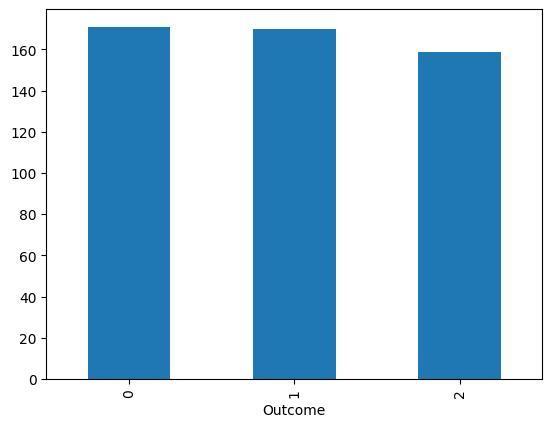

In [126]:
df.Outcome.value_counts().plot.bar()

## Detecting Missing Values
Calculate the percentage of missing values present in each column of the dataset.

In [127]:
missing_percent = df.isnull().sum() / len(df) * 100

In [128]:
missing_percent

Age                              5.0
Gender                           0.0
Diagnosis                        0.0
Symptom Severity (1-10)          0.0
Mood Score (1-10)                0.0
Sleep Quality (1-10)             0.0
Physical Activity (hrs/week)    10.0
Medication                       0.0
Therapy Type                     0.0
Treatment Start Date             0.0
Treatment Duration (weeks)       0.0
Stress Level (1-10)             20.0
Outcome                          0.0
Treatment Progress (1-10)        0.0
AI-Detected Emotional State      0.0
Adherence to Treatment (%)       0.0
dtype: float64

## Understanding the Causes Behind Missing Values
Using visualization tools such as heatmaps, and dendrograms, illustrate the interdependence between attributes with missing values. Also, visualize the distribution of the missing values within the dataset using matrices and bar charts.

<Axes: >

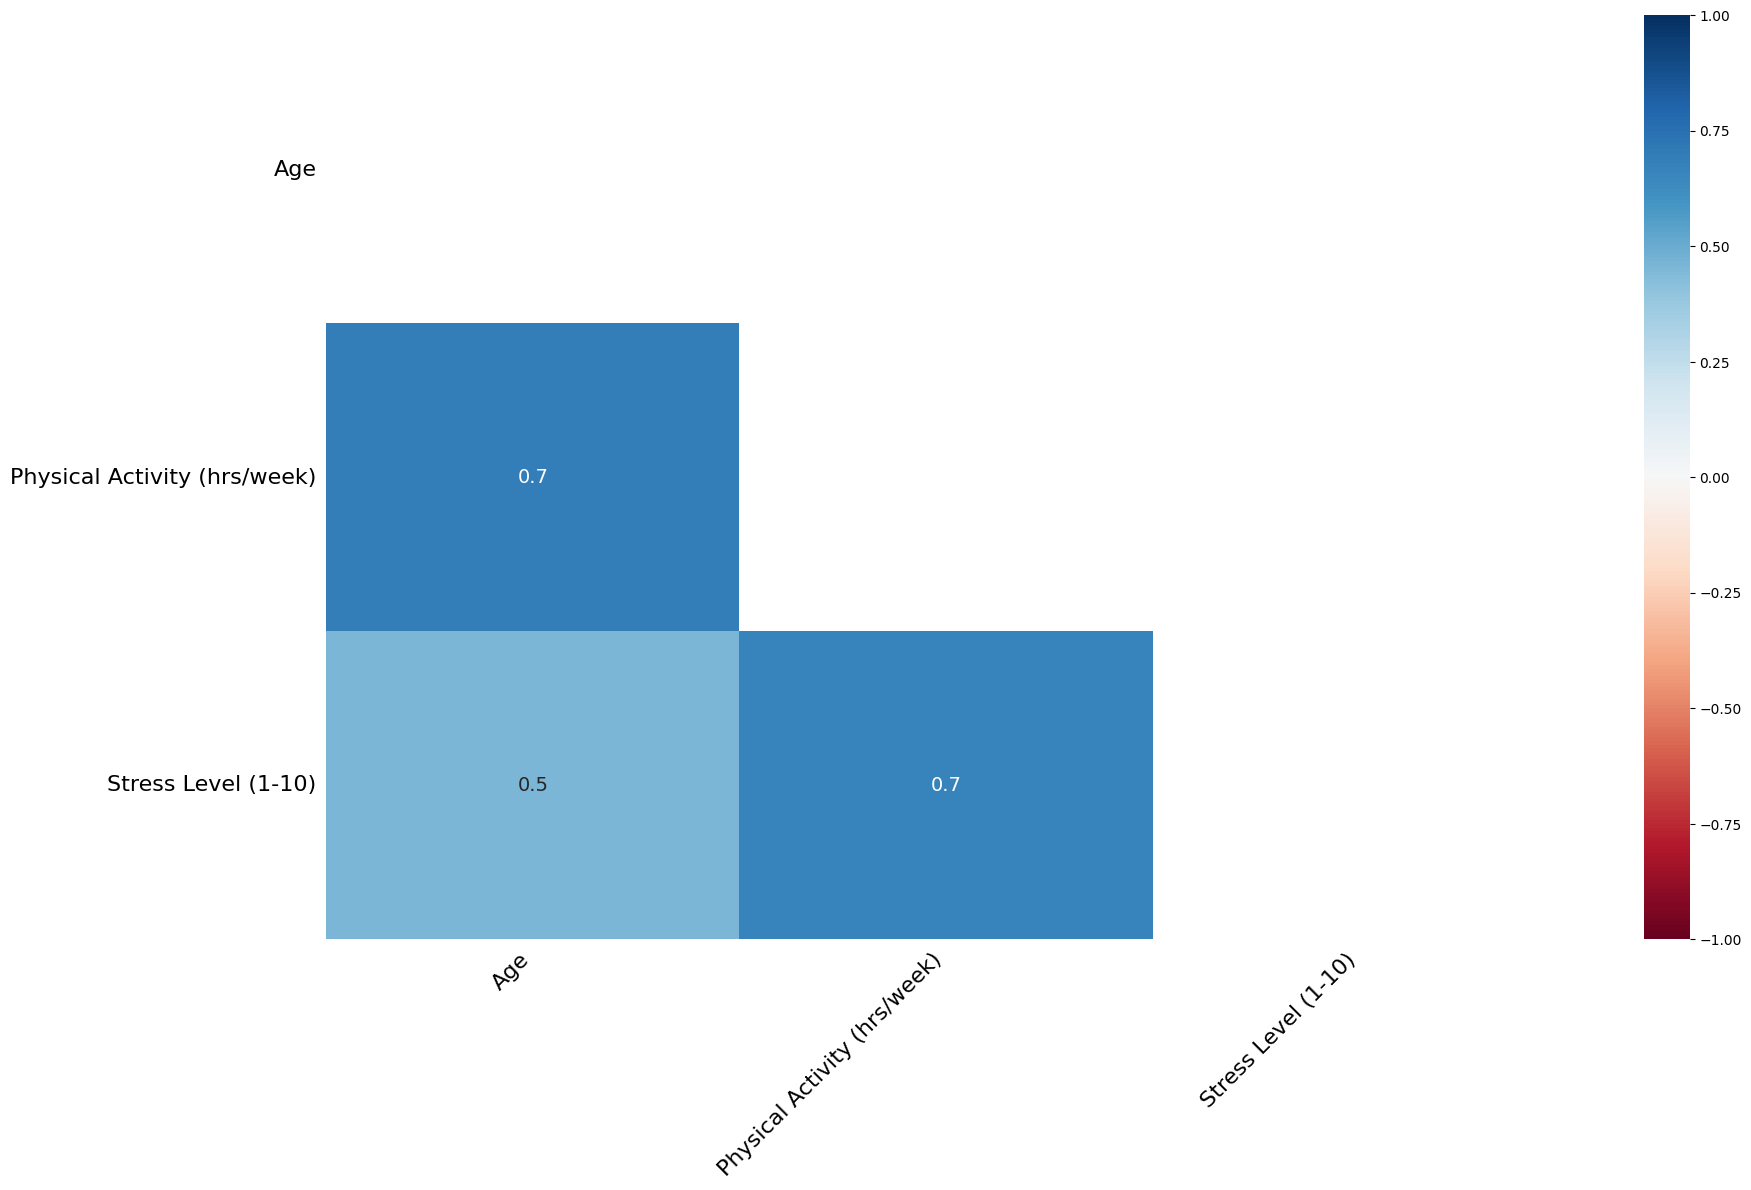

In [129]:
msno.heatmap(df)

## Handling the Missing Values
Handle the missing values using suitable method based on the insights obtained from the various visualizations.

In [130]:
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[['Age', 'Physical Activity (hrs/week)', 'Stress Level (1-10)']])

In [131]:
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(scaled_values)

In [132]:
imputed_data = scaler.inverse_transform(imputed_data)

In [133]:
imputed_data

array([[43. ,  6.6,  7.8],
       [40. ,  7. ,  7. ],
       [55. ,  4.8,  7. ],
       ...,
       [23. ,  4.4,  7.8],
       [48. ,  9. ,  6. ],
       [58. ,  2. ,  6. ]])

In [134]:
df[['Age', 'Physical Activity (hrs/week)', 'Stress Level (1-10)']] = imputed_data

In [135]:
df

,Age,Gender,Diagnosis,Symptom Severity (1-10),Mood Score (1-10),Sleep Quality (1-10),Physical Activity (hrs/week),Medication,Therapy Type,Treatment Start Date,Treatment Duration (weeks),Stress Level (1-10),Outcome,Treatment Progress (1-10),AI-Detected Emotional State,Adherence to Treatment (%)
0,43.000000,0,2,10,5,8,6.600000,4,2,2024-01-25,11,7.8000,0,7,0,66
1,40.000000,0,2,9,5,4,7.000000,1,2,2024-02-27,11,7.0000,2,7,4,78
2,55.000000,0,2,6,3,4,4.800000,5,3,2024-03-20,14,7.0000,0,5,3,62
3,34.000000,0,2,6,3,6,5.000000,5,3,2024-03-29,8,8.0000,0,10,2,72
4,52.000000,1,3,7,6,6,8.000000,2,2,2024-03-18,12,5.0000,0,6,2,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,38.623158,1,1,10,4,8,5.275556,4,1,2024-04-09,8,7.5675,1,10,1,73
496,22.000000,1,3,5,6,6,7.000000,3,3,2024-02-05,13,6.0000,0,8,3,86
497,23.000000,1,2,7,3,4,4.400000,0,0,2024-03-24,10,7.8000,0,5,4,87
498,48.000000,1,0,9,4,6,9.000000,0,3,2024-03-22,10,6.0000,1,7,0,73


In [136]:
df.isnull().sum()

Age                             0
Gender                          0
Diagnosis                       0
Symptom Severity (1-10)         0
Mood Score (1-10)               0
Sleep Quality (1-10)            0
Physical Activity (hrs/week)    0
Medication                      0
Therapy Type                    0
Treatment Start Date            0
Treatment Duration (weeks)      0
Stress Level (1-10)             0
Outcome                         0
Treatment Progress (1-10)       0
AI-Detected Emotional State     0
Adherence to Treatment (%)      0
dtype: int64

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

In [ ]:
df.drop('Treatment Start Date', axis=1, inplace=True)

In [139]:
target = 'Outcome'
X = df.drop(target, axis=1)
Y = df[target]

In [140]:
X

,Age,Gender,Diagnosis,Symptom Severity (1-10),Mood Score (1-10),Sleep Quality (1-10),Physical Activity (hrs/week),Medication,Therapy Type,Treatment Duration (weeks),Stress Level (1-10),Treatment Progress (1-10),AI-Detected Emotional State,Adherence to Treatment (%)
0,43.000000,0,2,10,5,8,6.600000,4,2,11,7.8000,7,0,66
1,40.000000,0,2,9,5,4,7.000000,1,2,11,7.0000,7,4,78
2,55.000000,0,2,6,3,4,4.800000,5,3,14,7.0000,5,3,62
3,34.000000,0,2,6,3,6,5.000000,5,3,8,8.0000,10,2,72
4,52.000000,1,3,7,6,6,8.000000,2,2,12,5.0000,6,2,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,38.623158,1,1,10,4,8,5.275556,4,1,8,7.5675,10,1,73
496,22.000000,1,3,5,6,6,7.000000,3,3,13,6.0000,8,3,86
497,23.000000,1,2,7,3,4,4.400000,0,0,10,7.8000,5,4,87
498,48.000000,1,0,9,4,6,9.000000,0,3,10,6.0000,7,0,73


In [141]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Feature Scaling
Standardize the features appropriately.

In [142]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Selection

Choose and train an approriate model for the given task.

In [176]:
model = DecisionTreeClassifier(max_depth=2)

In [177]:
model.fit(X_train_scaled, Y_train)

DecisionTreeClassifier(max_depth=2)

Use the trained model to make predictions for the test set.

In [178]:
y_pred = model.predict(X_test_scaled)

Assess the performance of the model by using different classification metrics.

In [179]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.22      0.28        18
           1       0.35      0.52      0.42        21
           2       0.12      0.09      0.11        11

    accuracy                           0.32        50
   macro avg       0.28      0.28      0.27        50
weighted avg       0.31      0.32      0.30        50



In [180]:
accuracy_score(Y_test, y_pred)

0.32

# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune at least one hyper-parameter using a cross-validation with grid search. This involves systematically experimenting with various values for the hyper-parameter(s) and evaluating the model's performance using cross-validation. Upon determining the most suitable value(s) for the hyper-parameter(s), evaluate the model's performance on a test set for final assessment.

Hint: Use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

In [219]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

## Feature Scaling
Standardize the features appropriately.

In [220]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [221]:
rkf = RepeatedKFold(n_splits=5)
rkf.get_n_splits(X, Y)

50

## Fine-tuning the Hyperparameters
Experiment with various values for the chosen hyperparameter(s) and evaluate the model's performance using cross-validation.

In [222]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 7]
}

model = DecisionTreeClassifier()

cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=rkf)
cv.fit(X_train_scaled, Y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7]})

## Final Assessment of the Model Performance
Upon determining the most suitable hyperparameter(s), evaluate the model's performance on a test set for final assessment.

In [223]:
cv.best_score_

0.3286666666666666

In [224]:
model = cv.best_estimator_

In [225]:
y_pred = model.predict(X_test_scaled)

In [226]:
print(classification_report(y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.53      0.32      0.40        25
           1       0.37      0.37      0.37        19
           2       0.25      0.67      0.36         6

    accuracy                           0.38        50
   macro avg       0.38      0.45      0.38        50
weighted avg       0.44      0.38      0.38        50

